# Explication de VGG19 
Nous faisons l'explication de l'architecture de réseau de neurones convolutifs (CNN) VGG (Visual Geometry Group) avec des valeurs de SHAP issues d'un Gradient Explainer.

In [1]:
import json 
import torch
import torchvision 
from torchvision import models
import shap 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


def normalize(image):
    if image.max() > 1:
        image /= 255
    image = (image - mean) / std
    # in addition, roll the axis so that they suit pytorch
    return torch.tensor(image.swapaxes(-1, 1).swapaxes(2, 3)).float()

In [3]:
# load the pre-trained vgg19 model, using 'image-net' set of weights
# it was trained on vgg19 dataset
model = models.vgg19(pretrained=True)

# Set the model to evaluation mode (no training)
model.eval()

# Load imagenet dataset (50 images aléatoires ainsi que leurs labels)
X,y = shap.datasets.imagenet50()

# Normaliser les valeures des pixels 
X /= 255

# Selections des images pour l'explication (index 1 et 2)
to_explain = X[[1,2,5]]

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.


In [4]:
# Récupérer les noms des classes d'ImageNet
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)  # Mise en cache du fichier si absent
with open(fname) as f:
    class_names = json.load(f)  # charger les noms de classes à partir du fichier JSON 

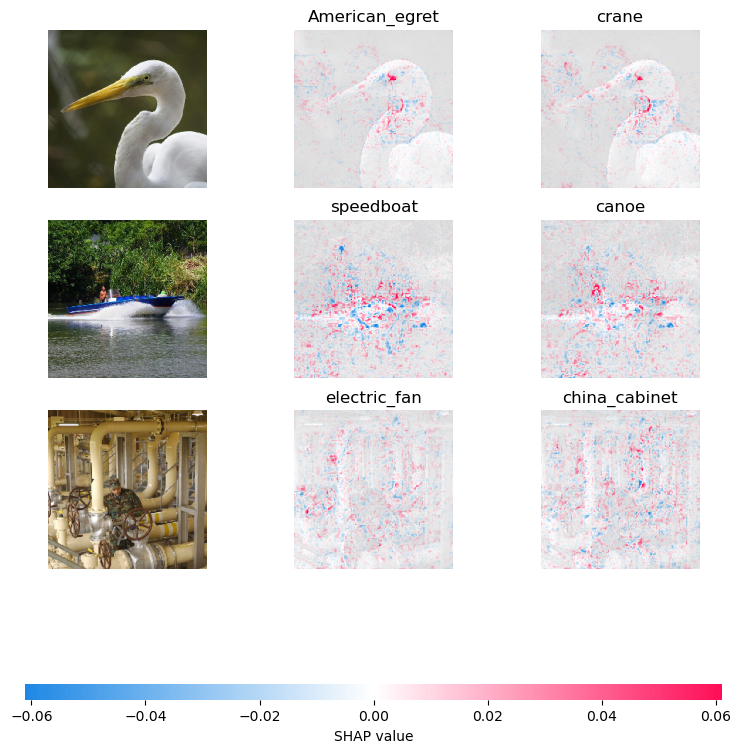

In [5]:
# Création d'un GradientExplainer, avec la 7eme couche du model pour expliquer la prédiction
e = shap.GradientExplainer((model, model.features[7]), normalize(X))

# Calcul des valeurs de SHAP et des indices pour l'explication des images choisies
shap_values, indexes = e.shap_values(
    normalize(to_explain), ranked_outputs=2, nsamples=2
)

# Noms des classes correspondant aux indices obtenus pour les images choisies
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# Organisation des valeurs de shap pour le graph 
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

# Afficher l'explication (Valeurs SHAP) avec les images et leur label de classe 
shap.image_plot(shap_values, to_explain, index_names)

In [ ]:
shap.image_plot(shap_values, to_explain, index_names)
plt.savefig("SHAP_vgg19_2.png")